In [1]:
library(tidyverse)
library(magrittr)
library(cowplot)
library(ggrepel)

brcaGenes <- c("ATM","BARD1","BLM","BRCA1","BRCA2","BRIP1","CDH1","CHEK2",
                "FAM175A","FANCC","FANCM","MLH1","MRE11","MSH2","NBN","NF1",
                "PALB2","PMS2","PTEN","RAD51B","RAD51C","RAD51D","RECQL",
                "RINT1","STK11","TP53")
sconesGenes <- c('C16orf97','CASC16','CASC21','CASC8','CCAT2','DIRC3','EOMES',
                 'FGF10-AS1','LOC100506674','TMEM106B','TOX3','LOC102467079',
                 'ARHGAP19-SLIT1','SLIT1','FGFR2','MRPS30','NEK10','SLC4A7')

gene2snp <- read_tsv("../../data/genesis/gene2snp.hg19", col_types = "cc") %>%
    set_colnames(c("snp", "gene"))
load("../../data/genesis/ld.RData")

highld <- Matrix::summary(ld) %>% 
    filter(x > 0.8) %>%
    mutate(i = rownames(ld)[i],
           j = rownames(ld)[j],
           key = paste(i, j, sep = "-"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# BOOST

In [2]:
boost <- read_tsv("genesis.processed.boost.txt", 
                  col_types = "iccdddddddddd") %>%
    filter(! (paste(SNP1, SNP2, sep = "-") %in% highld$key | 
              paste(SNP2, SNP1, sep = "-") %in% highld$key)) %>%
    merge(gene2snp, by.y = "snp", by.x = "SNP1") %>%
    merge(gene2snp, by.y = "snp", by.x = "SNP2") %>%
    arrange(-InteractionBOOST, -InteractionPLINK) 

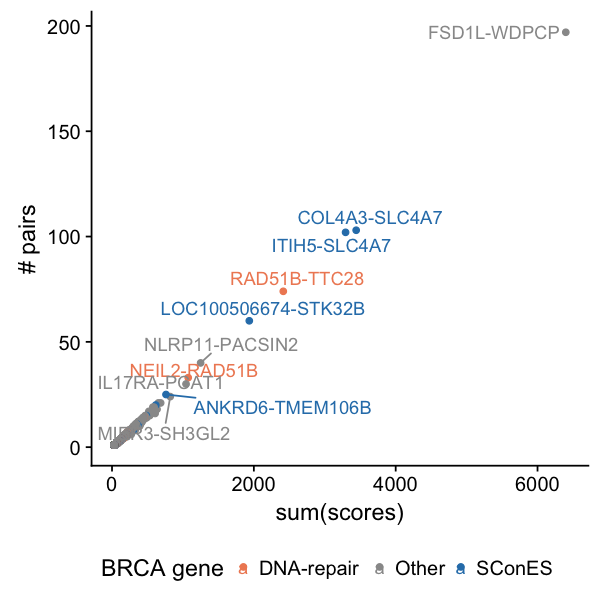

In [3]:
boostTop <- boost %>%
    mutate(gene1 = ifelse(gene.x < gene.y, gene.x, gene.y),
           gene2 = ifelse(gene.x < gene.y, gene.y, gene.x),
           genetype = ifelse(gene.x %in% brcaGenes | gene.y %in% brcaGenes, "DNA-repair", "Other"),
           genetype = ifelse(gene.x %in% sconesGenes | gene.y %in% sconesGenes, "SConES", genetype)) %>%
    unite(genepair, gene1, gene2, sep = "-") %>%
    group_by(genepair, genetype) %>%
    summarize(score = sum(InteractionBOOST),
              n = n()) %>%
    arrange(-score)

options(repr.plot.width=5, repr.plot.height=5)
ggplot() +
    geom_point(data = boostTop, aes(x = score, y = n, color = genetype)) +
    geom_text_repel(data = head(boostTop, 10), 
                     aes(x = score, y = n, label = genepair, color = genetype)) +
    scale_colour_manual(values = c("DNA-repair" = "#ef8a62", 
                                   "SConES" = "#2c7fb8",
                                   "Other" = "#999999")) +
    labs(x = "sum(scores)", y = "# pairs", color = "BRCA gene") +
    theme(legend.position="bottom")

# MBMDR

In [4]:
mbmdr <- read_table("genesis.processed.mbmdr.txt", col_types = "ccdd", skip = 2) %>%
    set_colnames(c("snp1", "snp2", "chi2", "p"))

filter(mbmdr, p < 0.05) %>% 
    merge(gene2snp, by.y = "snp", by.x = "snp1", all.x = T) %>%
    merge(gene2snp, by.y = "snp", by.x = "snp2", all.x = T, suffixes = c("1","2")) %>%
    select(gene1, gene2) %>%
    unique

gene1,gene2


# AntEpiSeeker

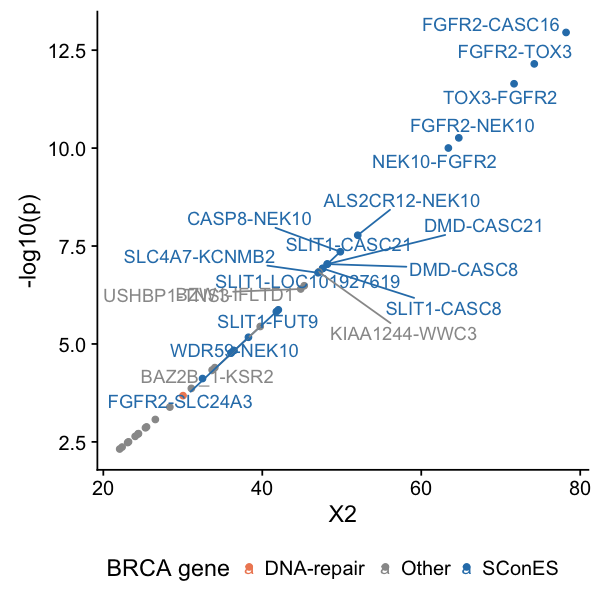

In [5]:
aes <- read_tsv("genesis.processed.aes.txt", col_types = "ccdd") %>%
    filter(! (paste(snp1, snp2, sep = "-") %in% highld$key | 
              paste(snp2, snp1, sep = "-") %in% highld$key)) %>%
    merge(gene2snp, by.y = "snp", by.x = "snp1", all.x = TRUE) %>%
    merge(gene2snp, by.y = "snp", by.x = "snp2", all.x = TRUE)  %>%
    mutate(genetype = ifelse(gene.x %in% brcaGenes | gene.y %in% brcaGenes, "DNA-repair", "Other"),
           genetype = ifelse(gene.x %in% sconesGenes | gene.y %in% sconesGenes, "SConES", genetype)) %>%
    unite(genepair, gene.x, gene.y, sep = "-") %>%
    filter(! (grepl("^NA-", genepair) | grepl("-NA$", genepair)))

ggplot() +
    geom_point(data = aes, aes(x = chi2, y = -log10(p), color = genetype)) +
    geom_text_repel(data = head(arrange(aes, p), 20), 
                    aes(x = chi2, y = -log10(p), color = genetype, label = genepair)) +
    scale_colour_manual(values = c("DNA-repair" = "#ef8a62", 
                                   "SConES" = "#2c7fb8",
                                   "Other" = "#999999")) +
    labs(x = "X2", y = "-log10(p)", color = "BRCA gene") +
    theme(legend.position="bottom")

In [6]:
merge(aes, boost, by.x = c("snp1", "snp2"), by.y = c("SNP1", "SNP2"))

snp1,snp2,chi2,p,genepair,genetype,index,singlelocusAssoc1,singlelocusAssoc2,InteractionBOOST,InteractionPLINK,p_singlelocusAssoc1,p_singlelocusAssoc2,p_InteractionBOOST,padj_singlelocusAssoc1,padj_singlelocusAssoc2,padj_InteractionBOOST,gene.x,gene.y


In [7]:
merge(aes, boost, by.x = c("snp1", "snp2"), by.y = c("SNP2", "SNP1"))

snp1,snp2,chi2,p,genepair,genetype,index,singlelocusAssoc1,singlelocusAssoc2,InteractionBOOST,InteractionPLINK,p_singlelocusAssoc1,p_singlelocusAssoc2,p_InteractionBOOST,padj_singlelocusAssoc1,padj_singlelocusAssoc2,padj_InteractionBOOST,gene.x,gene.y


There is no overlap between SNPs found by AntEpiSeeker and BOOST.